## Asycronous clients

This example illustrates how one can work with asyncronous clients using FEDn.

In [19]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from client.entrypoint import compile_model, load_parameters, make_data 


from fedn import APIClient
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import copy

import warnings
warnings.filterwarnings("ignore")

### ML model

As a centralized model baseline we generate synthetic data for a classification problem based on 4 features. We train a MLPClassifier on 80k training points, and test on 20k using ReLU activation, and Adam as optimizer, using a maximum of 1000 epochs.   

In [11]:
X, y = make_classification(n_samples=100000, n_features=4, n_informative=4, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We train a centralized baseline model for a maximum of 1000 epochs.  

In [16]:
clf = MLPClassifier(max_iter=1000)
clf.fit(X_train, y_train)
central_test_acc = accuracy_score(y_test, clf.predict(X_test))

print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy: ", accuracy_score(y_test, clf.predict(X_test)))

Training accuracy:  0.920925
Test accuracy:  0.92015


Next we simulate the training procedure of a single FL client. The client will in each interation draw a random number of training data points in the interval (50,100) from (X_train, y_train) and perform 'n_epochs' partial fits on that small sampled dataset. Then for each global round we test on the centralized test set (X_test, y_test). In this exepriment we simulate 1000 global rounds and the client performs 10 local epochs. 

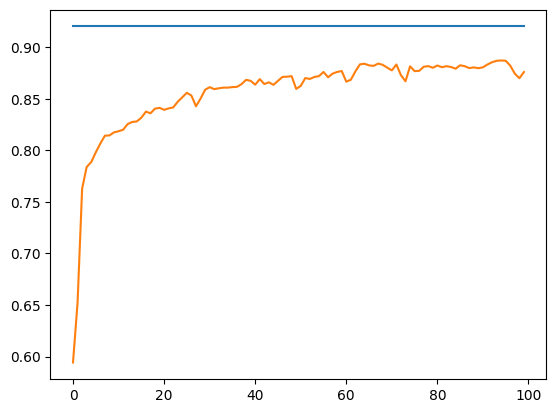

In [36]:
clf = compile_model()

n_global_rounds=100
n_epochs = 10
central_acc = []
for i in range(n_global_rounds):
    x,y,_,_ = make_data()
    for j in range(n_epochs):
        clf.partial_fit(x, y)
    central_acc.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(range(n_global_rounds),[central_test_acc]*n_global_rounds)
plt.plot(range(n_global_rounds), central_acc)

### Federated learning with 10 clients that stay online continously

Now we run federated learning with FEDn using 10 clients that stay online continously for the duration of the experiment. For this we will use the scripts 'run_clients.py' and 'run_experiment.py'.  

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [26]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Next, we retrive all model validations from all clients, extract the training accuracy metric, and compute its mean value accross all clients

In [27]:
def load_fedn_model(model_id):

    data = client.download_model(model_id, 'temp.npz')
    parameters = load_parameters('temp.npz')
    model = compile_model()
    n = len(parameters)//2
    model.coefs_ = parameters[:n]
    model.intercepts_ = parameters[n:]
    return model
    

Traverse the model trail and plot test accuracy on the central test set

In [39]:
model_trail = client.get_model_trail()

acc = []
for model in model_trail: 
    model = load_fedn_model(model['id'])
    acc.append(accuracy_score(y_test, model.predict(X_test)))

Plot the result.

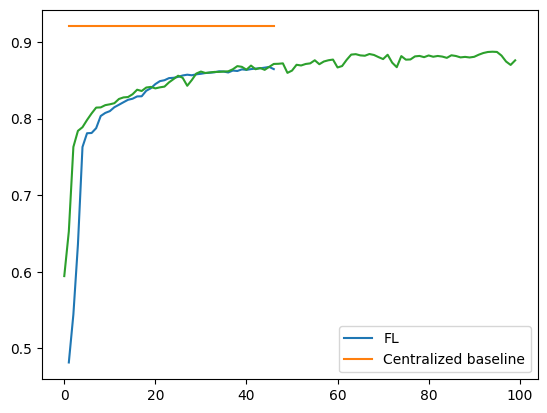

In [41]:
x = range(1,len(acc)+1)
plt.plot(x, acc)
plt.plot(x,[central_test_acc]*len(x))
plt.plot(range(n_global_rounds), central_acc)
plt.legend(['FL','Centralized baseline'])